In [8]:
#https://www.youtube.com/watch?v=qFJeN9V1ZsI&ab_channel=freeCodeCamp.org
#https://deeplizard.com/learn/video/LhEMXbjGV_4
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore',category = 'FutureWarning')
%matplotlib inline

## Data preparation

In [10]:
#we begin by using on train dir
#split train data into train, valid and test directory 

os.chdir('/Users/kamakshibanavalikar/Projects/Dog-VS-Cat/data/dogs-vs-cats') #change dir to dog-vs-cat dir
if os.path.isdir('train/dog') is False: #chck if the dir doesnt already exist
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
#making a subset of the origin dataset, 1000 train, 200 val and 100 test
    #1000 train
    for i in random.sample(glob.glob('cat*'), 1000): 
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 1000):
        shutil.move(i, 'train/dog')
    #200 val
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    #100 test
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

In [17]:
train_path = 'data/dogs-vs-cats/train'
test_path = 'data/dogs-vs-cats/test'
valid_path= 'data/dogs-vs-cats/valid'

In [18]:
#Putting images in the format of keras generator (since keras uses fit function and fit function uses a fprmat as input)
#it converts to batch and passes to the sequential model

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
#preprocess_input does some preprocessing to the img before they pass to the network we use
#vgg16 is a format in which img get passed
#.flow_from_directory is where we actually pass the data and spec how we want it to be processed
#target_size=(224,224) is hight and weight of the img
#classes=['cat', 'dog'] labelling
#shuffle=True

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
#shuffle=True

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)
#shuffle=False, for pred and conf matrix we need to access unshuffled data 


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [19]:
#chcking
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [20]:
imgs, labels = next(train_batches) 
#batch = 10, hence 10 img and 10 labels

In [21]:
#plotting img
#this function is from tf website
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

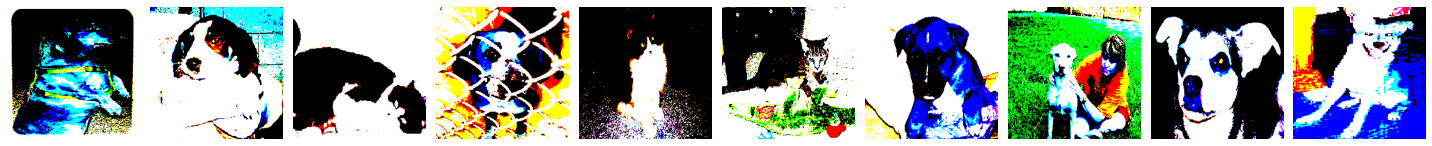

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [22]:
plotImages(imgs)
print(labels)

## Build CNN Model

In [25]:
model = Sequential([
    Conv2D(filters=32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape =(224,224,3)),
    MaxPool2D(pool_size = (2,2), strides =2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Flatten(), #converting to 1D
    Dense(units=2,activation = 'softmax'),   
])
#filters consist of kernels
#input_shape =(224,224,3), the target_size was 224x224 and the images are in RGB hence 3


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

## Prepare for training

In [27]:
model.compile(optimizer= Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics = ['accuracy'])

In [28]:
model.fit(x = train_batches, validation_data = valid_batches, epochs=10, verbose = 2)

Epoch 1/10
100/100 - 24s - loss: 21.8234 - accuracy: 0.5470 - val_loss: 10.2630 - val_accuracy: 0.5750
Epoch 2/10
100/100 - 24s - loss: 2.1925 - accuracy: 0.7740 - val_loss: 6.0598 - val_accuracy: 0.5350
Epoch 3/10
100/100 - 24s - loss: 0.6751 - accuracy: 0.8630 - val_loss: 3.2937 - val_accuracy: 0.5950
Epoch 4/10
100/100 - 25s - loss: 0.2832 - accuracy: 0.9350 - val_loss: 3.5532 - val_accuracy: 0.6000
Epoch 5/10
100/100 - 25s - loss: 0.0866 - accuracy: 0.9750 - val_loss: 3.2562 - val_accuracy: 0.6150
Epoch 6/10
100/100 - 23s - loss: 0.1094 - accuracy: 0.9710 - val_loss: 4.4000 - val_accuracy: 0.5600
Epoch 7/10
100/100 - 23s - loss: 0.0208 - accuracy: 0.9950 - val_loss: 3.0027 - val_accuracy: 0.6050
Epoch 8/10
100/100 - 24s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 3.1852 - val_accuracy: 0.6450
Epoch 9/10
100/100 - 24s - loss: 5.7304e-04 - accuracy: 1.0000 - val_loss: 3.1211 - val_accuracy: 0.6050
Epoch 10/10
100/100 - 24s - loss: 3.7553e-04 - accuracy: 1.0000 - val_loss: 3.1391 - 

## Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

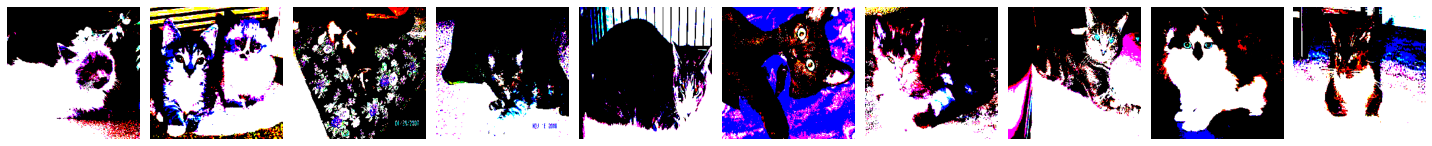

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [29]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [31]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [33]:
predictions = model.predict(x = test_batches, verbose = 0)

In [38]:
#np.round(predictions)

In [39]:
#true labels of the test set, along with the predicted labels for the test set from the model
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
#np.argmax, to pass index which has high probablity

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[33 17]
 [15 35]]


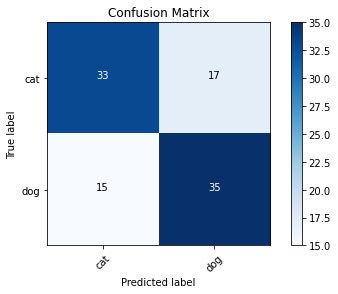

In [42]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')